In [ ]:
import torch
from torch import nn
#import torch.optim.lr_scheduler.StepLR
from torch.utils.data import DataLoader
import os
import math
import matplotlib.pyplot as plt

import numpy as np

from src import get_data_loaders

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

ModuleNotFoundError: No module named 'Load_Data'

# Load Data

In [ ]:
def get_data_loaders(batch_size=64, faste_files_to_load=37, normalize=False):
    Data = load_data(data_dir=os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Window'), 
                     train_val_data_to_load=math.inf,
                     test_data_to_load=math.inf,
                     faste_files_to_load=faste_files_to_load,
                     normalize=normalize)
    
    training_dataset, validation_dataset, testing_dataset = Data

    train_loader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=testing_dataset,
                              batch_size=batch_size,shuffle=True)
    return train_loader, val_loader, test_loader
data_dir=os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Window'), 
train_val_data_to_load=math.inf,
test_data_to_load=math.inf,
faste_files_to_load = 37
normalize = False
batch_size = 64
train_loader, val_loader, test_loader = get_data_loaders(
    data_dir, train_val_data_to_load, test_data_to_load, batch_size, faste_files_to_load, normalize=normalize)

Loading sequences from sequences.fasta
Loading coverage from SRX391990.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391996.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX1098138.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX391991.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX391995.faste
Loading coverage from SRX391997.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX1098137.faste
Loading coverage from SRX1098135.faste
Loading coverage from SRX1096550.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770790.

In [46]:
train_loader.dataset[10000]

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.]]),
 tensor([1.2548, 2.0942, 1.4883, 1.7982, 0.5817, 0.5548, 1.5211, 0.8783, 1.7505,
         1.2289, 1.8659, 0.8245, 1.4520, 1.1258, 1.8503, 1.4945, 0.7435, 0.6928,
         1.6268, 0.6366, 1.0402, 0.5742, 1.7171, 1.7846, 1.8448, 0.7149, 1.7520,
         1.7265, 1.6318, 1.0302, 2.2192, 1.8422, 1.4580, 1.8389, 1.2955, 0.6358,
         1.7055]))

# Build Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_kernels=[1024, 512, 256], kernel_size=[512,256,128],
                 dropout=0):
        super(SimpleCNN, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[0], 37),
            nn.ReLU(),  # ReLU ensures positive outputs
            # nn.LogSoftmax(dim=1)  # Apply log softmax if necessary for your task
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

## Local Model

In [ ]:
class LocalDnaCnn(nn.Module):
    def __init__(self, num_kernels=[256, 128, 64, 16], kernel_size=[16,24,48,10],
                 dropout=0, transformer_heads=4, transformer_layers=3):
        super(LocalDnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.transformer_heads=transformer_heads
        self.transformer_layers=transformer_layers
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            #nn.BatchNorm1d(num_features=num_kernels[1]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
            nn.MaxPool1d(kernel_size=2),        
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            #nn.BatchNorm1d(num_features=num_kernels[2]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),   
            nn.MaxPool1d(kernel_size=2),  
        ))
        # Add a fourth convolutional layer
        #self.conv_block.append(nn.Sequential(
        #    nn.Conv1d(in_channels=self.num_kernels[2],
        #              out_channels=num_kernels[3],
        #              kernel_size=kernel_size[3]),
        #    nn.ReLU(),
        #    nn.Dropout(p=self.dropout),         
        #))

        # the transformer is a combo of multiple encoder layers
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_kernels[2],
                                       nhead=self.transformer_heads,
                                       dim_feedforward=num_kernels[2]*2),
                                       self.transformer_layers)
        self.attention_weights = None  # Store attention weights
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[2], num_kernels[2]),
            nn.Linear(num_kernels[2], faste_files_to_load),
            #nn.ReLU(),  # ReLU ensures positive outputs
        ) 

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)  
        x = self.transformer(x)      
        x = self.regression_block(x)
        return x

# Train Model

### Training functions

In [49]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
    validation_loss /= num_batches
    if epoch%10 == 0 :
        print(f"Validation Loss: {validation_loss:>8f} \n")
    return validation_loss

def train_model(train_loader, val_loader, model, optimizer, loss_fn, epochs, overfit_ratio=0.85):

    train_loss = []
    validation_loss = []
    for t in range(epochs):
        if t % 1 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
        train_loss.append(loss)
        loss = validation(val_loader, model, loss_fn, t)
        validation_loss.append(loss)
    
        if train_loss[-1] < validation_loss[-1]:
            # print(f"Training loss {train_loss[-1]} is less than validation loss {validation_loss[-1]}")

            if train_loss[-1]/validation_loss[-1] < 0.80:
                print(f"Training loss {train_loss[-1]} is well below validation loss {validation_loss[-1]}")
                
    print("Done!")

    def plot_loss(train_loss, validation_loss):
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(train_loss)), train_loss, label='Training')
        plt.plot(np.arange(len(validation_loss)), validation_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # plt.savefig('')
        plt.show()
    plot_loss(train_loss, validation_loss)


### Train

In [50]:
num_kernels=[256, 128, 64, 8]
kernel_size=[16,16,16,10]
dropout=0.2
transformer_heads=4
transformer_layers=3
lr = 0.0001
faste_files_to_load=37

model = LocalDnaCnn(num_kernels=num_kernels,
                    kernel_size=kernel_size,
                    dropout=dropout,
                    transformer_heads=transformer_heads,
                    transformer_layers=transformer_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
train_model(train_loader, val_loader, model, optimizer, loss_fn, 50, 10)

/Users/tedmonyak/miniconda3/envs/gp/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0
-------------------------------
training loss: 0.911828
Validation Loss: 0.886455 

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
training loss: 0.832989
Validation Loss: 0.850878 

Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
training loss: 0.815505
Validation Loss: 0.86

KeyboardInterrupt: 

### Save Model

In [2]:
torch.save(model, "0511_3layer_CNN_transformer.pth")

NameError: name 'torch' is not defined

### Validate Model

In [ ]:
model = torch.load("model.pth", weights_only=False)
model.to(device)
model.eval()

In [42]:
X, y = next(iter(test_loader))
X = X.to(device)

y = y.to(device)
y_pred = model.forward(X).to(device)
y_pred = torch.exp(y_pred)

print(y[0])
print(y_pred[0])

loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
print(loss_fn(y_pred, y))

tensor([0.2278, 0.0000, 0.1504, 0.0000, 0.6088, 0.2943, 0.2320, 0.1896, 0.0000,
        0.2819, 0.0000, 0.2917, 0.0000, 0.0000, 0.0000, 0.1203, 0.3011, 0.0220,
        0.1469, 0.5855, 0.1733, 0.2718, 0.5351, 0.1708, 0.0956, 0.2229, 0.2439,
        0.0000, 0.0663, 0.0000, 0.0000, 0.0000, 0.0684, 0.0000, 0.4150, 0.1731,
        0.0000], device='mps:0')
tensor([0.3412, 0.1847, 0.2860, 0.1843, 0.3247, 0.3879, 0.2698, 0.3059, 0.1604,
        0.3318, 0.1689, 0.2403, 0.1428, 0.4194, 0.1637, 0.2647, 0.2741, 0.2795,
        0.2860, 0.3037, 0.2052, 0.3226, 0.3220, 0.3479, 0.3582, 0.3145, 0.3244,
        0.3156, 0.2939, 0.2073, 0.3360, 0.2204, 0.3125, 0.1557, 0.3019, 0.2960,
        0.3532], device='mps:0', grad_fn=<SelectBackward0>)
tensor(1.4564, device='mps:0', grad_fn=<MeanBackward0>)


In [22]:
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 0.947, 0.369
1: 0.704, 0.570
2: 0.702, 0.434
3: 0.635, 0.832
4: 0.905, 0.569
5: 0.650, 3.373
6: 0.713, 0.767
7: 0.869, 0.737
8: 0.704, 0.435
9: 0.799, 1.391
10: 0.637, 0.539
11: 0.671, 2.680
12: 0.611, 0.793
13: 0.755, 0.000
14: 0.646, 0.876
15: 0.679, 0.635
16: 0.606, 3.501
17: 0.683, 3.075
18: 0.685, 0.616
19: 0.687, 1.104
20: 0.702, 2.777
21: 0.748, 1.092
22: 0.715, 0.591
23: 0.759, 0.624
24: 0.786, 0.439
25: 0.748, 0.986
26: 0.739, 0.636
27: 0.692, 0.633
28: 0.671, 0.683
29: 0.687, 2.772
30: 0.839, 0.584
31: 0.734, 0.627
32: 0.687, 0.622
33: 0.647, 0.671
34: 0.928, 0.449
35: 0.700, 1.169
36: 0.755, 0.535


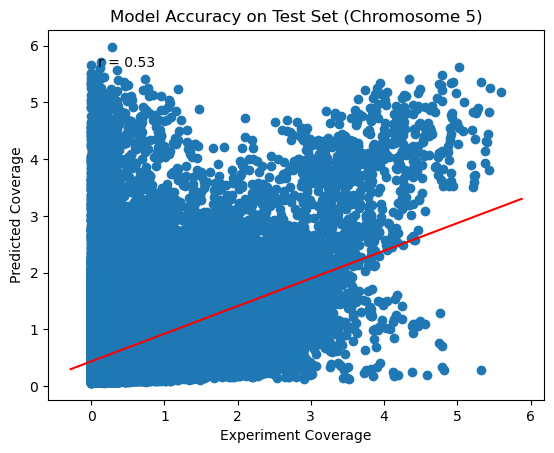

In [51]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            y_pred = torch.exp(y_pred)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)

            #y_pred = y_pred.cpu().detach().numpy().reshape(output.shape[0])
            #labels=target.cpu().numpy().reshape(output.shape[0])
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.savefig('LocalDnaCnnAccuracy.png')
plt.show()

In [28]:
def loss_true(input, target):
    return math.exp(input) - target*input

def loss_false(input, target):
    return input - target*math.log(input)


y = 0.5
y_mod = math.log(y+1)
print(y_mod)


y_pred = 0.5

print(loss_false(y_pred, y))

0.4054651081081644
0.8465735902799727


In [48]:
0.77/0.83


0.9277108433734941